In [1]:
import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import models
from dataset import UTKDataset
import wandb
import numpy as np
import random
from datetime import datetime
from cautious_extrapolation.utils import AverageMeter, save_checkpoint, kl_divergence_gaussian
from cautious_extrapolation.data_paths import DATA_PATHS
import pandas as pd
from sklearn.model_selection import train_test_split
from cautious_extrapolation.utils import get_imagenet_features
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import pickle
import matplotlib.pyplot as plt

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.49,), (0.23,))
])

dataFrame = pd.read_csv(os.path.join(DATA_PATHS["nfs"]["UTKFace"], 'age_gender.gz'), compression='gzip')
train_dataFrame, val_dataFrame = train_test_split(dataFrame, test_size=0.2, random_state=42)


val_loader = torch.utils.data.DataLoader(
    UTKDataset(val_dataFrame, transform=normalize),
    batch_size=64, shuffle=False,
    num_workers=4)

val_features = get_imagenet_features(val_loader, UTKFace=True)
idxs = np.random.permutation(len(val_features))
val_features = val_features[idxs]


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
ood_scores = []
for corruption_level in range(5):
    ood_loader = torch.utils.data.DataLoader(
        UTKDataset(val_dataFrame, severity=corruption_level+1, transform=normalize),
        batch_size=64, shuffle=False,
        num_workers=4)
    ood_features = get_imagenet_features(ood_loader, UTKFace=True)
    idxs = np.random.permutation(len(ood_features))
    ood_features = ood_features[idxs]
    num_points = min(len(val_features), len(ood_features))
    ood_features_train = ood_features[:int(0.9*num_points)]
    val_features_train = val_features[:int(0.9*num_points)]
    X = np.concatenate((val_features_train, ood_features_train), axis=0)
    y = np.concatenate((np.ones(int(0.9*num_points)), np.zeros(int(0.9*num_points))), axis=0)


    scores = []
    for _ in range(10):
        clf = make_pipeline(StandardScaler(), SGDClassifier(loss="log", max_iter=20, alpha=10))
        clf.fit(X, y)
        score = clf.predict_log_proba(ood_features[int(0.9*num_points):])[:, 0].mean()
        scores.append(score)

    ood_scores.append(np.mean(scores))

/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '

In [5]:
ood_scores

[-0.5227557042934002,
 -0.29845413898152334,
 -0.17530152230600202,
 -0.1710694641924912,
 -0.14270550774678462]

In [5]:
label_mean = val_loader.dataset.age_label.mean()
label_std = val_loader.dataset.age_label.std()

In [10]:
dir_path = os.path.dirname(os.path.abspath("__file__"))
dataset_types = ['train', 'ood']


run_names = ["seed0_2023_06_12_17_43_26", "seed1_2023_06_12_18_22_14", "seed2_2023_06_12_18_25_32", "seed3_2023_06_12_18_35_49", "seed4_2023_06_12_18_32_12"]

kls_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs.pkl"), 'rb') as f:
        data = pickle.load(f)
    
    kls = []
    for level in range(6):
        kl=  kl_divergence_gaussian(data[level][:, 0], data[level][:, 1], label_mean*np.ones(len(data[level])), label_std*np.ones(len(data[level])))
        kls.append(kl.mean())
    kls_all.append(kls)

kls_all = np.array(kls_all)


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


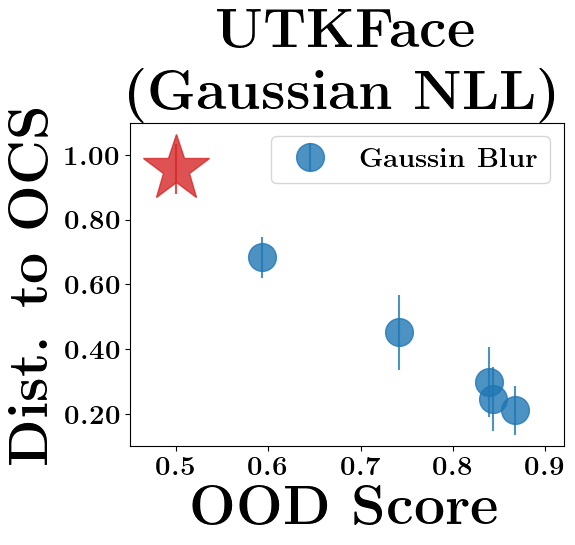

In [13]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

plt.rcParams["figure.figsize"] = np.array([6.4, 4.8])/4*3.5
plt.figure()
ax = plt.gca()

plt.errorbar([0.5], [kls_all.mean(axis=0)[0]], yerr=[kls_all.std(axis=0)[0]], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
plt.errorbar(np.e**np.array(ood_scores), kls_all.mean(axis=0)[1:], yerr=kls_all.std(axis=0)[1:], fmt='o', markersize=20, alpha=0.8, color=colors[1], label=r"\textbf{Gaussin Blur}")


plt.xlabel(r"\textbf{OOD Score}", fontsize=40)

plt.ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
plt.title(r"\textbf{UTKFace}"+"\n"+r"\textbf{(Gaussian NLL)}", fontsize=40)
plt.yticks([0.2+_*0.2 for _ in range(10)], [r"\textbf{%.2f}"%(0.2+_*0.2) for _ in range(10)], fontsize=20)
plt.xticks([0.5+0.1*_ for _ in range(5)], [r"\textbf{%.1f}"%(0.5+0.1*_) for _ in range(5)], fontsize=20)
plt.ylim([0.1, 1.1])
plt.xlim([0.45, 0.92])
plt.legend(fontsize=20, loc='upper right')
plt.show()

In [14]:
ood_scores = [-0.5227557042934002,
 -0.29845413898152334,
 -0.17530152230600202,
 -0.1710694641924912,
 -0.14270550774678462]

In [15]:
dir_path = os.path.dirname(os.path.abspath("__file__"))
dataset_types = ['train', 'ood']


run_names = ["seed0_2023_06_12_17_43_26", "seed1_2023_06_12_18_22_14", "seed2_2023_06_12_18_25_32", "seed3_2023_06_12_18_35_49", "seed4_2023_06_12_18_32_12"]

kls_all = []
for run_name in run_names:
    with open(os.path.join(dir_path, "data", run_name, "outputs_impulse_noise.pkl"), 'rb') as f:
        data = pickle.load(f)
    
    kls = []
    for level in range(6):
        kl=  kl_divergence_gaussian(data[level][:, 0], data[level][:, 1], label_mean*np.ones(len(data[level])), label_std*np.ones(len(data[level])))
        kls.append(kl.mean())
    kls_all.append(kls)

kls_all = np.array(kls_all)


/home/katie/miniconda3/envs/cifar10/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  


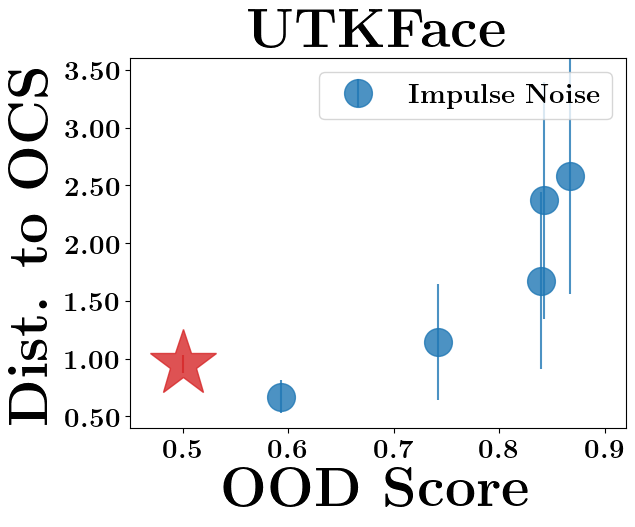

In [18]:
import matplotlib as mpl
from matplotlib import rc

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

colors=["C3", "C0", "C1", "C2", "C4", "C5", "C6", "C7", "C8", "C9"]

plt.rcParams["figure.figsize"] = np.array([6.4, 4.8])
plt.figure()
ax = plt.gca()

plt.errorbar([0.5], [kls_all.mean(axis=0)[0]], yerr=[kls_all.std(axis=0)[0]], fmt='*', markersize=50, zorder=100, alpha=0.8, color=colors[0])
plt.errorbar(np.e**np.array(ood_scores), kls_all.mean(axis=0)[1:], yerr=kls_all.std(axis=0)[1:], fmt='o', markersize=20, alpha=0.8, color=colors[1], label=r"\textbf{Impulse Noise}")


plt.xlabel(r"\textbf{OOD Score}", fontsize=40)

plt.ylabel(r"\textbf{Dist. to OCS}", fontsize=40)
plt.title(r"\textbf{UTKFace}", fontsize=40)
plt.yticks([0.5+_*0.5 for _ in range(10)], [r"\textbf{%.2f}"%(0.5+_*0.5) for _ in range(10)], fontsize=20)
plt.xticks([0.5+0.1*_ for _ in range(5)], [r"\textbf{%.1f}"%(0.5+0.1*_) for _ in range(5)], fontsize=20)
plt.ylim([0.4, 3.6])
plt.xlim([0.45, 0.92])
plt.legend(fontsize=20, loc='upper right')
plt.show()